In [94]:
import pandas as pd
from hazm import Normalizer, word_tokenize, Stemmer, Lemmatizer, stopwords_list
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE


In [2]:
df = pd.read_csv("./golestan.csv")

print(df.shape)
print(df.columns)


(290, 2)
Index(['hekayt', 'bab'], dtype='object')


In [3]:
df.head()

,hekayt,bab
0,پادشاهی را شنیدم به کُشتنِ اسیری اشارت کرد. بی...,1
1,یکی از ملوکِ خراسان محمودِ سبکتگین را به خواب ...,1
2,ملک‌زاده‌ای را شنیدم که کوتاه بود و حقیر و دیگ...,1
3,طایفهٔ دزدانِ عرب بر سرِ کوهی نشسته بودند و من...,1
4,سرهنگ‌زاده‌ای را بر در سرایِ اُغْلُمُش دیدم که...,1


In [4]:
df = df.dropna(subset=["hekayt"])
df = df.dropna(subset=["bab"])

print(df.shape)
print(df.columns)

(290, 2)
Index(['hekayt', 'bab'], dtype='object')


In [5]:
df["bab"].value_counts()

bab
8    109
2     48
1     41
3     28
5     21
7     20
4     14
6      9
Name: count, dtype: int64

In [6]:
normalizer = Normalizer()
stemmer = Stemmer()
lemmatizer = Lemmatizer()

In [13]:
base_stopwords = set(stopwords_list())

In [22]:
extra_stopwords = {
    "است", "هست", "بود", "شد", "باشد",
    "می", "هم", "را", "که", "با", "از", "برای",
    "ای", "این", "آن", "من", "تو", "ما", "شما", "او",
}

additional_stopwords = set()

for i in extra_stopwords:
    print(f'if {i} is in stopwords list? {i in base_stopwords}')
    if i not in base_stopwords: 
        additional_stopwords.add(i)

additional_stopwords

if شما is in stopwords list? True
if از is in stopwords list? True
if ای is in stopwords list? False
if شد is in stopwords list? True
if ما is in stopwords list? True
if هم is in stopwords list? True
if تو is in stopwords list? True
if را is in stopwords list? True
if او is in stopwords list? True
if این is in stopwords list? True
if برای is in stopwords list? True
if که is in stopwords list? True
if با is in stopwords list? True
if آن is in stopwords list? True
if باشد is in stopwords list? True
if من is in stopwords list? True
if است is in stopwords list? True
if هست is in stopwords list? False
if بود is in stopwords list? True
if می is in stopwords list? True


{'ای', 'هست'}

In [26]:
stopwords = base_stopwords.union(additional_stopwords)

print(len(base_stopwords))
print(len(stopwords))

389
391


In [41]:
def preprocess_hekayat(text):
    text = str(text)

    text = normalizer.normalize(text)

    tokens = word_tokenize(text)
    tokens = [t for t in tokens if re.search(r"[آ-یءئ]", t)]
    tokens = [t for t in tokens if t not in stopwords]

    tokens_stemmed = [stemmer.stem(t) for t in tokens]

    return " ".join(tokens_stemmed)


In [50]:
df["clean_hekayt"] = df["hekayt"].apply(preprocess_hekayat)

In [49]:
df.to_csv("golestan_clean.csv", index=False)
df[["hekayt", "clean_hekayt"]].head()

,hekayt,clean_hekayt
0,پادشاهی را شنیدم به کُشتنِ اسیری اشارت کرد. بی...,پادشاه شنید کشتن اسیر اشار بیچاره حال نومید مل...
1,یکی از ملوکِ خراسان محمودِ سبکتگین را به خواب ...,ملوک خراس محمود سبکتگین خواب چن دید جمله ریخته...
2,ملک‌زاده‌ای را شنیدم که کوتاه بود و حقیر و دیگ...,ملک‌زاده شنید کوتاه حقیر برادر بلند خوب‌رو بار...
3,طایفهٔ دزدانِ عرب بر سرِ کوهی نشسته بودند و من...,طایفه دزد عرب سر کوه نشسته_بودند منفذ کارو بست...
4,سرهنگ‌زاده‌ای را بر در سرایِ اُغْلُمُش دیدم که...,سرهنگ‌زاده سرا اغلم دید عقل کیاست فه فراست زای...


In [52]:
tfidf_vectorizer = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1, 1),
    use_idf=True,
    smooth_idf=True,
    sublinear_tf=True  
)

In [70]:
x_tfidf = tfidf_vectorizer.fit_transform(df["clean_hekayt"])

In [79]:
tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()
tfidf_feature_names[:30]


array(['آب', 'آباد', 'آبرو', 'آبگینه', 'آت', 'آتش', 'آثار', 'آجل', 'آحاد',
       'آخر', 'آد', 'آداب', 'آدم', 'آدمی', 'آدمیس', 'آدینه', 'آذارند',
       'آر', 'آرا', 'آراستن', 'آراسته', 'آرد', 'آرزو', 'آرمیده', 'آرند',
       'آز', 'آزاد', 'آزادگ', 'آزار', 'آزر'], dtype=object)

In [80]:
k = 5
kmeans = KMeans(
    n_clusters=k,
    init='k-means++',
    n_init=10,
    max_iter=300,
    random_state=42
)

In [85]:
X = x_tfidf
y_true = df["bab"]


In [82]:
kmeans.fit(X)

,n_clusters,5
,init,'k-means++'
,n_init,10
,max_iter,300
,tol,0.0001
,verbose,0
,random_state,42
,copy_x,True
,algorithm,'lloyd'


In [83]:
cluster_labels = kmeans.labels_
print(cluster_labels[:20])        # first 20 hekayat cluster IDs
print("Inertia:", kmeans.inertia_)


[1 1 1 1 1 2 1 2 0 4 2 1 1 1 2 1 1 1 2 2]
Inertia: 276.19238580053707


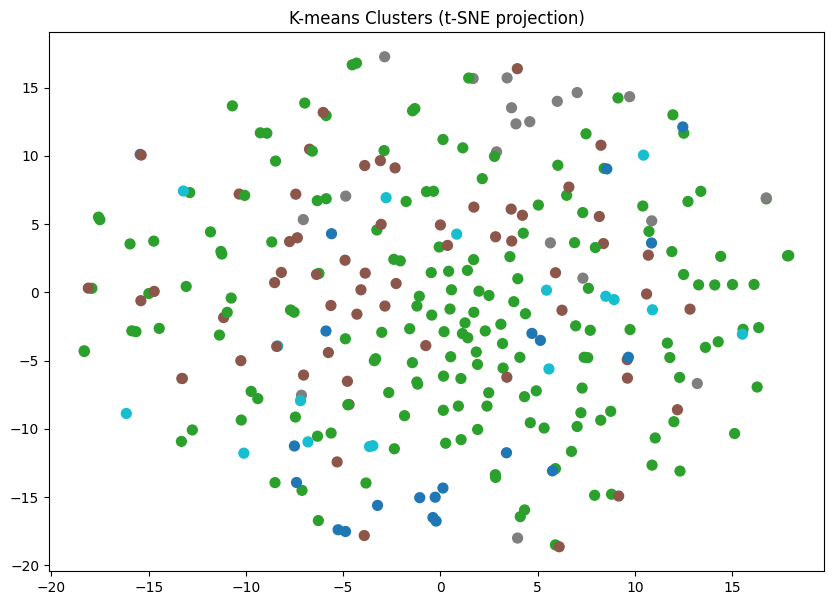

In [95]:

tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_tsne = tsne.fit_transform(x_tfidf.toarray())

plt.figure(figsize=(10, 7))
plt.scatter(
    X_tsne[:,0],
    X_tsne[:,1],
    c=cluster_labels,
    cmap='tab10',
    s=50
)
plt.title("K-means Clusters (t-SNE projection)")
plt.show()



In [98]:
centers = kmeans.cluster_centers_
centers.shape

(5, 5000)

In [100]:
import numpy as np

for c in range(k):
    print(f"\nTop words for cluster {c}:")
    center = centers[c]
    top_idx = center.argsort()[::-1][:15]  # top 15 words
    for i in top_idx:
        print(tfidf_feature_names[i], center[i])




Top words for cluster 0:
اجل 0.053879493538774595
پا 0.04879018768807404
پیاده 0.03537338581170127
سر 0.03523674255794274
ماه 0.03518369574537247
آهسته 0.03255381525146897
آید 0.03053904547788434
عمر 0.029804126541305237
سال 0.0296827208746251
سخت 0.02948948666647419
بی 0.029138941012490316
شب 0.028905348163210505
روز 0.028662280638980377
ندا 0.0284724495139079
ضعیف 0.028250768717379863

Top words for cluster 1:
دس 0.02719619045053034
سخن 0.025242563789676542
می 0.024476060249879115
سر 0.02283443289281337
که 0.02180837899998573
کن 0.021576621547943455
گر 0.0212222410814764
گف 0.02121937675628815
کس 0.02030960352129889
دل 0.02005755226148139
چو 0.019936545127352597
آن 0.019479029632901303
بی 0.019218605473175117
ملک 0.01874010467002557
دید 0.018154206253653504

Top words for cluster 2:
بی 0.033682694063254685
خدا 0.033590928602720706
ملک 0.029717412616547652
کار 0.028724329632051883
پادشاه 0.023916190868887566
سر 0.023197115579244573
چو 0.02281562307448846
به 0.022793532021960723
دل 0.